In [1]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from scipy import interpolate
from scipy.fftpack import fft,ifft
from numpy.fft import rfft,irfft
from scipy.cluster.vq import vq,kmeans,whiten
from scipy import conj,argmax
from scipy.signal import periodogram

In [2]:
logFileName = 'PT357'
dataFile = logFileName+'.01.csv'


df=pd.read_csv(dataFile) 
#df.head()
loopIteration   = df[ 'loopIteration'].values.T
time            = df[ ' time (us)'].values.T
#print(time[0])
averageUs = np.median(np.diff(time-time[0]))
sampling_rate = 1000000/averageUs
nyquist_freq = sampling_rate/2
print(sampling_rate)

3215.434083601286


In [3]:
df.columns
setpointData    = df[[ ' setpoint[0]',  ' setpoint[1]', ' setpoint[2]']].values.T
gyroADCData     = df[[ ' gyroADC[0]',   ' gyroADC[1]',  ' gyroADC[2]']].values.T
gyroScaleData   = df[[ ' debug[0]',     ' debug[1]',    ' debug[2]']].values.T
thrData         = df[[ ' rcCommand[3]']].values.T[0]

1537


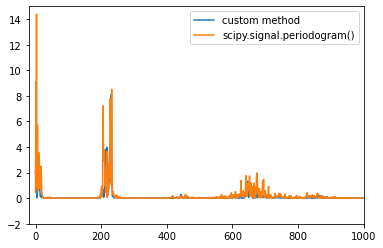

In [12]:
def abs2(x):
    return x.real**2 + x.imag**2
buffer_size = 1024 * round(sampling_rate/1000)
buffer_size_ng = round(nyquist_freq)
signal = gyroScaleData[0]
idx = 11608

freq2,power2 = periodogram(signal[idx-int(buffer_size/2):idx+int(buffer_size/2)],sampling_rate, window=('kaiser',6), detrend='constant', return_onesided=True, scaling='density', axis=- 1)

def power_spectrum(input_signal,sampling_rate,mode=None):
    
    buffer_size = round(nyquist_freq) # take half secsignal
    new_buffer_size = 1024 * round(sampling_rate/1000) # padding to power of 2
    pxx = np.zeros(round(new_buffer_size/2),dtype=np.float64)

    sig_wnd = np.kaiser(buffer_size,6) * input_signal
    # the kaiser window with beta = 6 has the most ideal shape on both main lobe and side lobos
    # when beta = 6, it might looks like a hanning, but not the same
    wnd = np.kaiser(buffer_size,6)*1 # the real shape of the window
    sig_wnd_pad = np.pad(sig_wnd,
                            (0,(new_buffer_size-len(sig_wnd))),
                            'constant',constant_values =(0,0))
                            # padding to power of 2
    sig_fft = np.fft.rfft(sig_wnd_pad) # fft to the padded signal
    result = abs2(sig_fft) # calculate its power spectrum, but without power correction

    if mode == 'density':
        scaling_factor = 1.0 / (sampling_rate * (wnd*wnd).sum() )
        # scaling_factor when in density mode
    elif mode == 'spectrum':
        scaling_factor = 1.0 / wnd.sum()**2
        # scaling)_factor when in spectrum mode

    pxx = scaling_factor*result
    # This is the result
    return pxx

# let's make a compare
pxx = power_spectrum(signal[idx:idx+buffer_size_ng],sampling_rate, mode='density')
print(len(pxx))
plt.figure()
plt.plot(pxx, label='custom method')
plt.plot(power2,label='scipy.signal.periodogram()')
plt.legend()
plt.xlim(-20,1000)
plt.ylim(-2,15)
#plt.xlim(0,20)
#plt.xlim(0,np.max(freq[0:int(len(y)/2+1)]))
plt.show()


In [23]:

new_buffer_size = 1024 * round(sampling_rate/1000)
buffer_size = round(nyquist_freq)
signal = gyroScaleData[0]
#batch = int(len(signal)/buffer_size)
#thr_psd = np.zeros((100, int(buffer_size/2)), dtype=np.float64)
thr_psd = np.zeros((100, round((1024 * round(sampling_rate/1000))/2)+1), dtype=np.float64)
thrCount = np.zeros(100, dtype=np.int32)
thr = thrData/10 - 100

print(round(1024 * round(sampling_rate/1000))+1)

for i in range(0, len(signal)-buffer_size, round(buffer_size/30)):
    idx = i
    avgThr = int(np.mean(thr[idx:idx+buffer_size]))
    if avgThr < 0:
        avgThr = 0
    if avgThr > 99:
        avgThr = 99
    pxx = power_spectrum(signal[idx:idx+buffer_size],sampling_rate, mode='density')
    #print(len(Pxx_den))
    #print(max(f))
    #break
    thr_psd[avgThr]= thr_psd[avgThr]+pxx
    thrCount[avgThr] += 1
    
for i in range(100):
    if thrCount[i] != 0:
        thr_psd[i]=thr_psd[i]/thrCount[i]

3073


In [24]:
thr_psd_log = np.zeros((100, int(buffer_size/2)+1), dtype=np.float64)
thr_psd_log = np.log10(thr_psd)
maxdb = np.zeros(100, dtype=np.float64)
mindb = np.zeros(100, dtype=np.float64)
hz = np.zeros(100, dtype=np.int32)
j=0
for i in range(0,99,1):
    maxdb[j] = max(thr_psd_log[i,100:])
    hz[j] = np.argmax(thr_psd_log[i,100:])
    j += 1
k=0
for i in range(0,99,1):
    mindb[k] = min(thr_psd_log[i,50:])
    k += 1
print(np.argmax(hz))
print(hz[np.argmax(maxdb)])
print(len(thr_psd_log[1,]))

62
308
1537


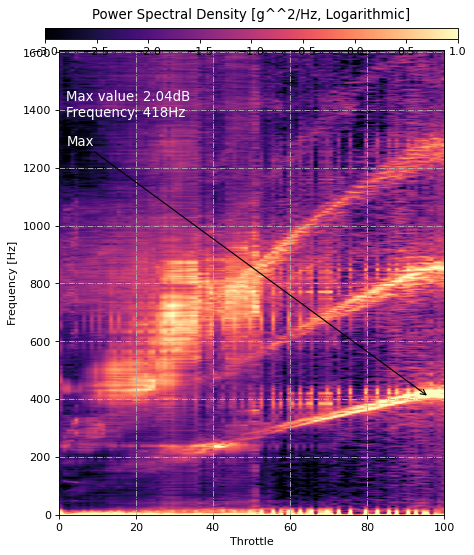

In [25]:
plt.figure(figsize=(6, 7), dpi= 80)
plt.imshow(thr_psd_log.T, cmap='magma', vmin=-3, vmax=1, aspect=0.075, interpolation='kaiser', origin='lower', extent=[0, 100, 0, nyquist_freq])

plt.grid(True,linestyle='-.')

plt.xlabel('Throttle')
plt.ylabel('Frequency [Hz]')
plt.text(2,nyquist_freq-230,'Max value: %.2fdB \nFrequency: %dHz' %(max(maxdb),(1.025*(100+hz[np.argmax(maxdb)]))),c='w',size=12)


#text = (     'Max value: %f \nFrequency: %dHz' %(   max(maxdb) ,   (50+hz[np.argmax(maxdb)])   )     )
plt.plot(np.argmax(maxdb), max(maxdb), 'g')
plt.annotate('Max', c='w',size=12, xy=(np.argmax(maxdb), (100+hz[np.argmax(maxdb)])), xytext=(2, nyquist_freq-330), arrowprops=dict(arrowstyle='->'))

plt.subplots_adjust(top=0.93, bottom=0.1, left=0.12, right=0.98, wspace=0.1, hspace=0)
cax = plt.axes([0.12, 0.95, 0.86, 0.02])
plt.colorbar(cax=cax, orientation='horizontal')
plt.title('Power Spectral Density [g^^2/Hz, Logarithmic]', y=1.2)
#position= plt.axes([0.125, 0.8, 0.775, 0.04])
#plt.colorbar(cax=position,orientation='horizontal')
plt.show()